In [1]:
# Import libraries
import os
import time
import warnings
import random

import keras
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from scipy import interp
from skimage.feature import hog
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer, roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Set to ignore warnings
warnings.filterwarnings("ignore")

random.seed(42)

In [2]:
# Include word count for Markdown cells
import io
from nbformat import current

filepath = './CMM536_coursework__1608118.ipynb'

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'ipynb')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == 'markdown':
        word_count += len(cell['source'].replace('#','').lstrip().split(' '))

print(f'Notebook word count: {word_count}')

Notebook word count: 805


# Data Loading

In [3]:
# Create function to load ultrasound images
def load_images(path: str, resize: bool=True, resize_width: int=128, resize_height: int=128) -> tuple:
    """
    Function used to load images from the given folder
    :path - the path to the folder
    :resize - whether the images should be resized
    :resize_width - target width for resize
    :resize_height - target height for resize
    :returns - 
    """
    images = []
    images_flattened = []
    labels = []
    
    for root, dirs, files in os.walk(path):
        for file in files:
            with open(os.path.join(root, file), 'r') as image_f:
                try:
                    # Load the image from the folder
                    img = cv2.imread(root + '/' + file, 0)
                    # If 'resize' is True, resize the image 
                    if resize:
                        img = cv2.resize(img, (resize_width, resize_height))
                    images.append(img) # Append the image in 2D
                    images_flattened.append(img.flatten()) # Append the flattened image
                    labels.append(root.split('/')[-1]) # Append the class label
                except Exception as e:
                    # If an exception occurs skip
                    continue
                    # print(f'Invalid file: {file} skipped')
                    
    return (np.array(images), np.array(images_flattened), labels)

In [4]:
# Load images separately - open, closed & non-heart
# Define the paths to the folders
heart_open_path = './data/heart/open'
heart_closed_path = './data/heart/closed'
non_heart_path = './data/non-heart'

# Define image scale
IMG_HEIGHT=128
IMG_WIDTH=128

# Load the images using the 'load_images' function
open_images, open_images_flattened, open_target = load_images(path=heart_open_path)
closed_images, closed_images_flattened, closed_target = load_images(path=heart_closed_path)
non_heart_images, non_heart_images_flattened, non_heart_target = load_images(path=non_heart_path)

# Test the images have been loaded
print(f'Shape of the 3D image numpy array for "open": {open_images.shape}')
print(f'Length of the flattened numpy array for "open": {open_images_flattened.shape}')
print(f'Sample of the target class labels for "open": {len(open_target)}')

Shape of the 3D image numpy array for "open": (138, 128, 128)
Length of the flattened numpy array for "open": (138, 16384)
Sample of the target class labels for "open": 138


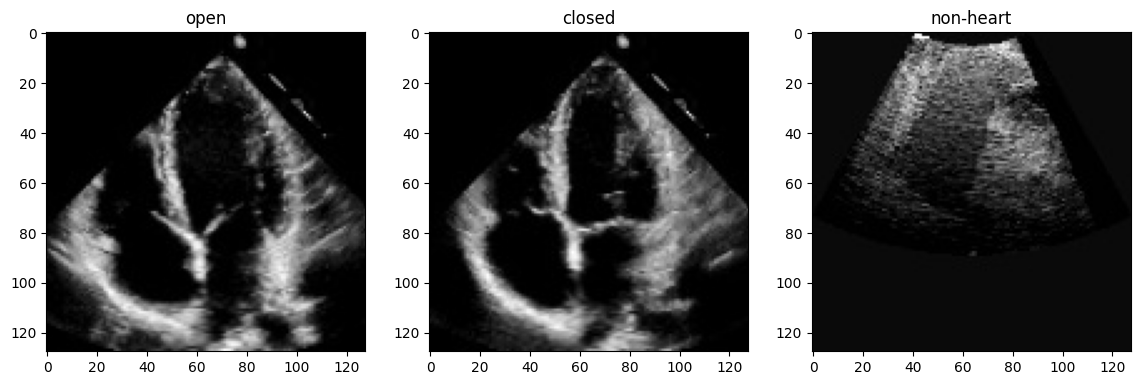

In [5]:
# Visualize an image from each category
def visualize_by_category(categories: list, images: list) -> None:
    """
    A function to visualize a list of images using pyplot
    :categories - a list of labels corresponding to the images
    :images - a list of images to visualize
    :returns - None
    """
    categories_and_images = list(zip(categories, images))
    
    plt.figure(figsize=(14,8))
    
    for i in range(len(categories_and_images)):
        plt.subplot(1,len(categories_and_images),i+1)
        plt.imshow(categories_and_images[i][1], cmap='grey')
        plt.title(categories_and_images[i][0])

    plt.show()

images_to_visualize = [open_images[0], closed_images[0], non_heart_images[0]]
categories = [open_target[0], closed_target[0], non_heart_target[0]]

visualize_by_category(categories, images_to_visualize)

# Task 1

### Distinguish between abdominal and heart ultrasounds

In [6]:
# Prepare the data
# Concatenate image data for all three types
images = np.concatenate((open_images, closed_images, non_heart_images))
images_flattened = np.concatenate((open_images_flattened, closed_images_flattened, non_heart_images_flattened))
target = np.concatenate((open_target, closed_target, non_heart_target))

print(f'Shape of all 3D images numpy array: {images.shape}')
print(f'Shape of all flattened 2D images numpy array: {images_flattened.shape}')

# Update target labels - 'open' & 'closed' to 'heart', then convert them into numerical
target = ['heart' if t in ['open', 'closed'] else 'non-heart' for t in target]
target = [1 if label == 'heart' else 0 for label in target] # non-heart: 0, heart: 1

# Print the label count
print(f'Class labels count: {Counter(target)}')

Shape of all 3D images numpy array: (1143, 128, 128)
Shape of all flattened 2D images numpy array: (1143, 16384)
Class labels count: Counter({0: 925, 1: 218})


All images are loaded! Class labels ("open" & "closed") for heart images are combined into "heart", then converted to numerical

In [7]:
# Define a function to extract HOG features from images
def extract_hog(images: list, visualize: bool=False) -> list:
    """
    A function to extract HOG features for images
    :images - a list of images to get HOG features for
    :visualize - whether to return a HOG image
    :returns - a list of HOG data
    """
    hog_data = []
    for image in images:
        hog_result = hog(
            image,
            orientations=9,
            pixels_per_cell=(8,8),
            cells_per_block=(2,2),
            visualize=visualize
        )
        hog_data.append(hog_result)

    return hog_data

In [8]:
# Get HOG features for the images
hog_features = extract_hog(images)

print(f'Length of extracted HOG features: {len(hog_features)}')
print(f'Size of the HOG features for each image: {hog_features[0].shape}')

Length of extracted HOG features: 1143
Size of the HOG features for each image: (8100,)


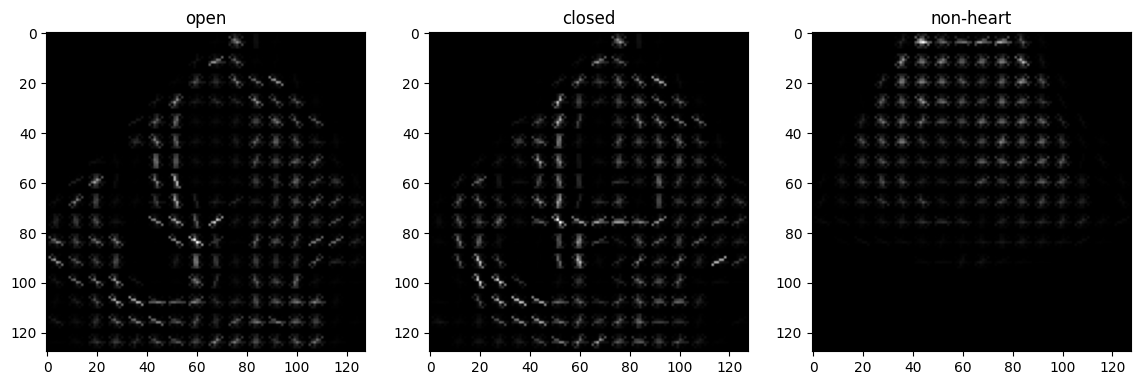

In [9]:
# Visualize what the HOG features look like, using the same images visualized from before
# Get the HOG images by setting visualize to True
hog_images = extract_hog(images_to_visualize, visualize=True)

# Note: when setting 'visualize' to True, 'hog' returns a tuple, including both the features and the image, therefore
# hog_images looks like this [(hog_features, hog_image), (hog_features, hog_image),...]
# Images must be extracted first
hog_images = [hog_data[-1] for hog_data in hog_images]

# Using the 'visualize_by_category' function to show HOG images
visualize_by_category(categories, hog_images)

The visualized HOG features show a clear distinction between heart & non-heart, interestingly the Mitral valve and its position (open or closed) is also clearly visible. 

In [10]:
# Split the data into train/test ensuring equal distribution of labels for both sets
X_train, X_test, y_train, y_test = train_test_split(hog_features, target, stratify=target, test_size=0.25)

train_label_counts = np.unique(y_train, return_counts=True)[-1]
test_label_counts = np.unique(y_test, return_counts=True)[-1]

print(f'Train label counts: {train_label_counts}')
print(f'Test label counts: {test_label_counts}')

Train label counts: [694 163]
Test label counts: [231  55]


Class imbalance - using stratified splitting to ensure that the heart images are equally represented for both training and testing

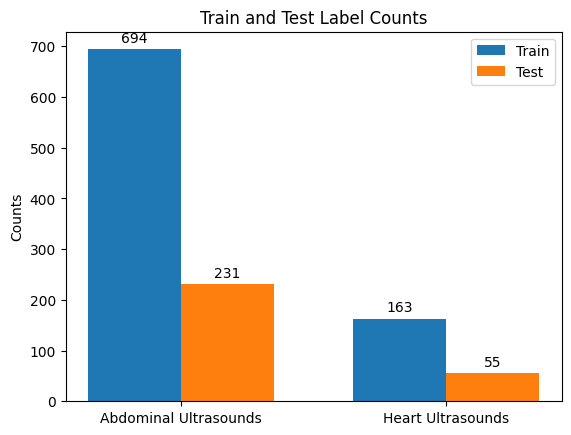

In [11]:
# Visualize the distribution of class labels in both the train and test sets
categories = ['Abdominal Ultrasounds', 'Heart Ultrasounds']

# Create an array with the x locations for the groups
x = np.arange(len(categories))
width = 0.35  # Width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_label_counts, width, label='Train')
rects2 = ax.bar(x + width/2, test_label_counts, width, label='Test')

ax.set_ylabel('Counts')
ax.set_title('Train and Test Label Counts')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Function to add counts on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Offset above the bar
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

### Non-NN classifier (Support Vector Machine)

In [12]:
# Train a Support Vector Machine (Non NN classifier) to distinguish between heart and non-heart images
# Instantiate the classifier with a 'linear' kernel
clf = SVC(kernel='linear')

# Fit the classifier to the training data
clf.fit(X_train, y_train)

SVC(kernel='linear')

In [13]:
# Test and evaluate the result from SVM using different scoring metrics
# Get the classifier's predictions for the test data
y_predicted = clf.predict(X_test)

# Evaluate results using precision, recall and f1
print(f'Precision: {precision_score(y_test, y_predicted)}')
print(f'Recall: {recall_score(y_test, y_predicted)}')
print(f'F1 Score: {f1_score(y_test, y_predicted)}')

Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [14]:
# Use a 5-fold cross-validation to verify results
print(f'Mean Cross-Val Precision: {np.mean(cross_val_score(clf, hog_features, target, cv=5, scoring="precision"))}')
print(f'Mean Cross-Val Recall: {np.mean(cross_val_score(clf, hog_features, target, cv=5, scoring="recall"))}')
print(f'Mean Cross-Val F1: {np.mean(cross_val_score(clf, hog_features, target, cv=5, scoring="f1"))}')

Mean Cross-Val Precision: 1.0
Mean Cross-Val Recall: 1.0
Mean Cross-Val F1: 1.0


#### Evaluation:

The classifier has achieved a "perfect" result classifying all images correctly. As seen above, the images don't share much in common, therefore it might be an easy problem for the classifier to address.

### NN-based (Vanilla CNN) classifier

In [15]:
# Create the Vanilla-CNN classifier using a function definition
def create_model(img_height: int, img_width: int):
    """
    Function to dynamically generate vanilla-CNN 
    """
    model = keras.models.Sequential([
        keras.layers.Conv2D(32, kernel_size=3, activation='relu', input_shape=[img_height,img_width,1]),
        keras.layers.MaxPooling2D(2),
        keras.layers.Conv2D(64, kernel_size=3, activation='relu'),
        keras.layers.MaxPooling2D(2),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [16]:
# Instantiate a model and print model summary

model = create_model(img_height=IMG_HEIGHT, img_width=IMG_WIDTH)
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       3,686,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,705,345 (14.13 MB)

 Trainable params: 3,705,345 (14.13 MB)

 Non-trainable params: 0 (0.00 B)

None


In [17]:
# Split the image data (pixels) into train/test, with stratified sampling using pixel data
X_train, X_test, y_train, y_test = train_test_split(images, target, stratify=target, test_size=0.25)

print(f'Shape of training data: {X_train.shape}')
print(f'Shape of training labels: {len(y_train)}')
print(f'Shape of test data: {X_test.shape}')
print(f'Shape of test labels: {len(y_test)}')

Shape of training data: (857, 128, 128)
Shape of training labels: 857
Shape of test data: (286, 128, 128)
Shape of test labels: 286


In [18]:
# Preprocess input data
def preprocess_image_input(image_data, img_height, img_width):  
    image_data = image_data.reshape(image_data.shape[0], img_height, img_width, 1)
    image_data = image_data.astype('float32') # Convert the values into type 'float32' for training data
    image_data_normalized = image_data / 255 # Normalize pixel values between 0-1

    return image_data_normalized

# Normalize both train and test data
X_train_normalized = preprocess_image_input(X_train, IMG_HEIGHT, IMG_WIDTH)
X_test_normalized = preprocess_image_input(X_test, IMG_HEIGHT, IMG_WIDTH)

# Convert class labels into a numpy array
y_train = np.array(y_train)
y_test = np.array(y_test)

In [19]:
# Fit the data to the model
# Set hyperparams
EPOCHS=3
BATCH_SIZE=16

# Fit the data to the model
model.fit(X_train_normalized, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

# Evaluate the model using the test data
loss, accuracy = model.evaluate(X_test_normalized, y_test, verbose=0)
print(f'Loss: {loss}\nAccuracy: {accuracy}')

Epoch 1/3
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.9478 - loss: 0.0918
Epoch 2/3
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 1.0000 - loss: 1.5413e-07
Epoch 3/3
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 1.0000 - loss: 9.5553e-08
Loss: 9.603757676265867e-13
Accuracy: 1.0


In [20]:
# Evaluate the vanilla-CNN using precision, recall and f1
y_pred = model.predict(X_test)

print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step 
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [21]:
# Wrap the CNN with KerasClassifier to use with sklearn cross_validate
cnn_clf = KerasClassifier(build_fn=create_model, img_height=IMG_HEIGHT, img_width=IMG_WIDTH, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

# Define the scoring metrics for evaluation
scoring = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

In [22]:
X = np.concatenate((X_train_normalized, X_test_normalized), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# Perform 5-fold cross validation for vanilla-CNN
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = cross_validate(cnn_clf, X, y, cv=cv, scoring=scoring)

print(f'Mean Cross-Val Precision: {np.mean(results["test_precision"])}')
print(f'Mean Cross-Val Recall: {np.mean(results["test_recall"])}')
print(f'Mean Cross-Val F1: {np.mean(results["test_f1"])}')

Mean Cross-Val Precision: 1.0
Mean Cross-Val Recall: 1.0
Mean Cross-Val F1: 1.0


#### Evaluation:

Similarily to the non-NN classifier, the vanilla CNN has also achieved a "perfect" result distinguishing between heart and abdominal ultrasound images. After cross-validation the model achieved an average of a 100% across all performance metrics. 

# Task 2

### Distinguish between open and closed heart ultrasounds

Both SVC and vanilla-CNN have achieved a perfect result in the first task, since CNNs generally more computationally expensive (although it was not a criteria to measure run times in Task 1, cross validation for vanilla-CNN took significantly longer than SVC), as well as the heart image dataset is relatively small, Task 2 will be performed using SVC first, before trying to improve in Task 3 using Transfer Learning. 

In [23]:
# Get only heart (open & closed) images and corresponding labels by concatenating pre-loaded data
images = np.concatenate((open_images, closed_images))
target = np.concatenate((open_target, closed_target))

# Convert target labels into numerical values
target = [1 if label == 'open' else 0 for label in target] # closed: 0, open: 1

print(images.shape)
print(len(target))
print(f'Class labels count: {Counter(target)}')

(218, 128, 128)
218
Class labels count: Counter({1: 138, 0: 80})


The data is more balanced than in task 1, however, their is still a slight imbalance between the amount of open and closed heart ultrasounds

In [24]:
hog_features = np.array(extract_hog(images))

print(hog_features[0].shape)

(8100,)


In [25]:
# Convert class labels into a numpy array
y = np.array(target)

In [26]:
# Define helper functions to help visualizing performance metrics
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_true, y_pred_proba):.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Aggregated ROC Curve Across Folds")
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(confusion_matrices):
    agg_conf_matrix = sum(confusion_matrices) # calculate aggregated confusion matrix across folds

    plt.figure(figsize=(10,10))
    plt.title("Aggregated Confusion Matrix Across Folds")
    classes = ["Closed", "Open"]
    labels = ['TN','FP','FN','TP']
    labels = np.asarray(labels).reshape(2,2)
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    
    group_counts = ['{0:0.0f}'.format(value) for value in
                    agg_conf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         agg_conf_matrix.flatten()/np.sum(agg_conf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(agg_conf_matrix, annot=labels, fmt='', cmap= "YlGn" ,
                xticklabels = classes,yticklabels = classes
               )

In [27]:
# Instantiate the same SVC model used in Task 1
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf = SVC(kernel='linear')

precision_scores, recall_scores, f1_scores, confusion_matrices = [], [], [], []
y_true_all = []
y_pred_proba_all = []

start_time = time.perf_counter()

for train_idx, test_idx in cv.split(hog_features, y):
    X_train, X_test = hog_features[train_idx], hog_features[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    clf.fit(X_train, y_train)
    y_pred_proba = clf.predict(X_test)

    y_pred_proba_all.extend(y_pred_proba)
    y_true_all.extend(y_test)
    
    y_pred = (y_pred_proba >= 0.5).astype(int)   
    
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    confusion_matrices.append(confusion_matrix(y_test, y_pred))

print(f'Elapsed time for 5-fold cross validation: {time.perf_counter() - start_time}')

Elapsed time for 5-fold cross validation: 1.0009798000000103


A stratified 5-fold cross validation is performed using the SVC classifier from task 1. Evaluation metrics & confusion matrix is calculated and stored after each fold, then aggregated to evaluate performance. Predictions results on test data and true values are also saved during each fold. 

Mean Cross-Val Precision: 0.9716566320014597
Mean Cross-Val Recall: 0.9634920634920634
Mean Cross-Val F1: 0.967231111967954


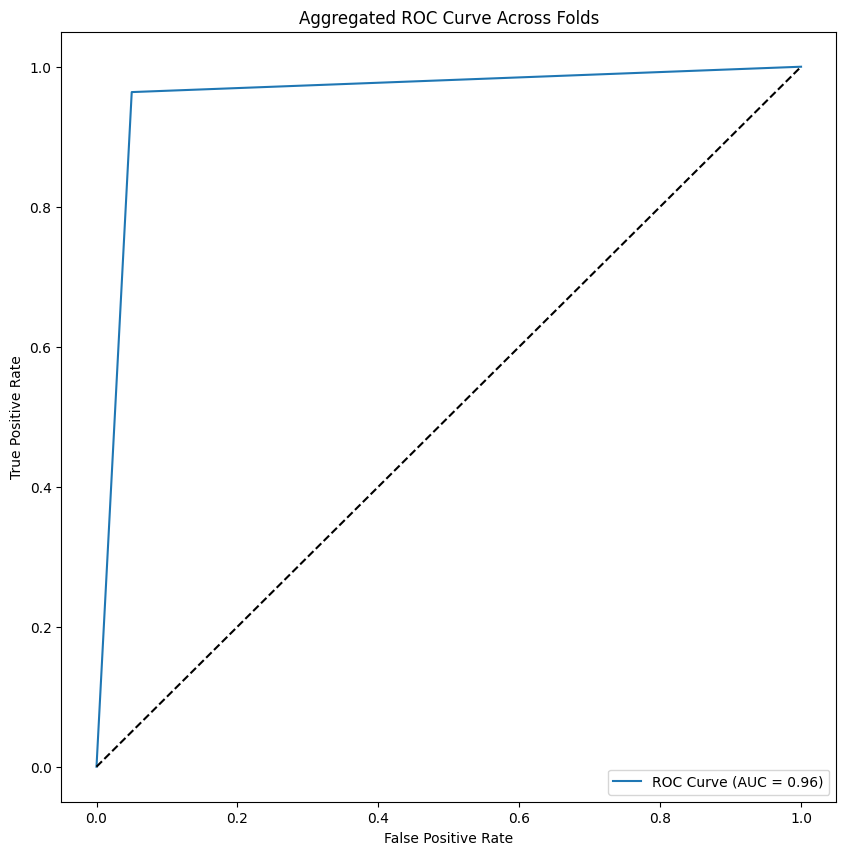

In [28]:
print(f'Mean Cross-Val Precision: {np.mean(precision_scores)}')
print(f'Mean Cross-Val Recall: {np.mean(recall_scores)}')
print(f'Mean Cross-Val F1: {np.mean(f1_scores)}')

plot_roc_curve(y_true_all, y_pred_proba_all)

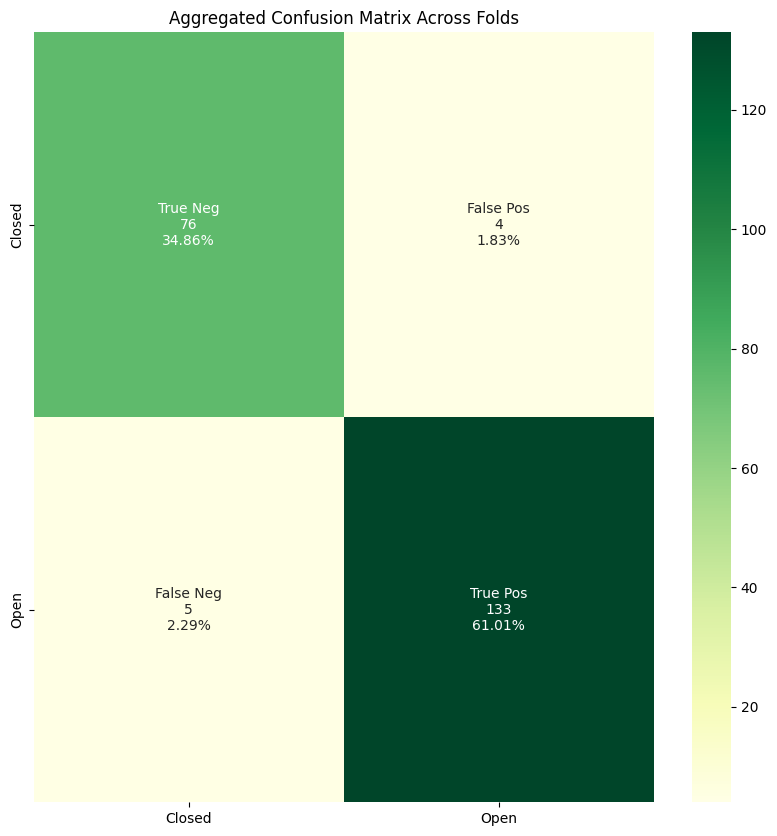

In [29]:
plot_confusion_matrix(confusion_matrices)

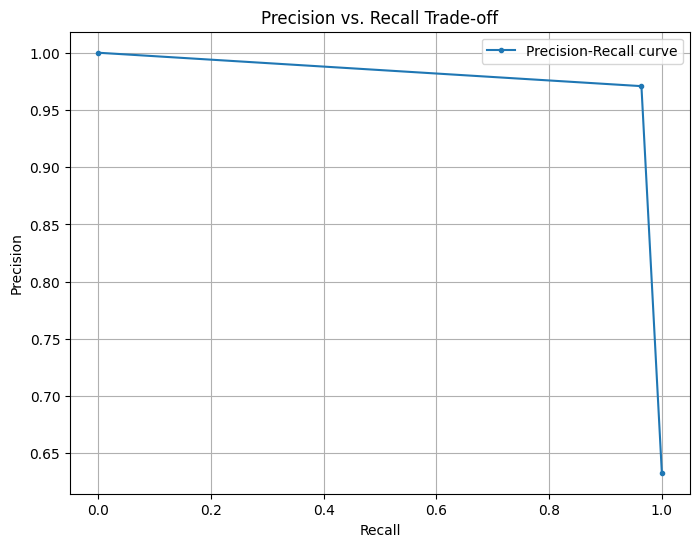

In [30]:
precision_vals, recall_vals, thresholds = precision_recall_curve(y_true_all, y_pred_proba_all)
# Plot the precision-recall curve.
plt.figure(figsize=(8,6))
plt.plot(recall_vals, precision_vals, marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall Trade-off')
plt.legend()
plt.grid(True)
plt.show()

#### Evaluation:



* Runtime: Due to the dataset being rather small, the runtime to perform cross-validation is quick
* Performance:
  The classifier still performed relatively well, however compared to task 1, results were worse when comparing open vs closed
  - The precision of the classifier refers to the accuracy of the predictions when predicting positive classes (TP/(TP + FP)), the classifier is 97% accurate when predicting positive classes, meaning that only a small number of images are misclassified as positive.
  - The sensitivity (recall - TP/(TP+FN)) of the classifier is slightly lower, which refers to how well the classifier is able to detect positive classes. Here the recall is slightly lower than precision, suggesting a slightly higher rate of false negatives.
  - F1 score is the harmonic mean between precision and recall, giving more weight to lower values, hence f1 score is being closer to the lower recall score
  - The ROC curve, shows the True Positive Rate against the False Positive Rate (with the dotted line representing the curve of a purely random classifier) - the curve indicates consistently good performance across folds. The AUC score shows that the classifier is able to distinguish between open and closed ultrasounds with 96% probability.
  - The confusion matrix quanitifies the earlier dicussed and shows, that the classifier wrongly classified 4 images where the valve was originally closed (but the classifier thought it was open) and 5 images were classified as closed when in reality they were open.


# Task 3

### Improve results from task 2

Use image augmentation to increase the diversity of the training data, then apply Transfer Learning to benefit from pre-learned features

In [31]:
# Set up the VGG16 pre-trained model loaded in from keras.applications
base_model = tf.keras.applications.VGG19(
    include_top=False, # Exclude the ImageNet classifier at the top
    weights='imagenet', # Load the weights pre-trained on ImageNet
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3) # Set the shape of the input
)

# Allow the last 5 layers in the model to be trained 
base_model.trainable = True
for layer in base_model.layers[:-5]:
    layer.trainable = False

def get_pretrained(img_height, img_width):
    inputs = layers.Input(shape=(img_height, img_width, 3))
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.00005), # Use a very low learning tate to avoid overfitting quickly
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

VGG19 pre-trained on ImageNet is used for Transfer Learning. Keeping the top layers frozen to preserve more generic features learnt from ImageNet, while unfreezing the final 5 layers to allow the model to adapt more to heart ultrasounds.

In [32]:
# Pre-process image pixel values
X = preprocess_image_input(images, IMG_HEIGHT, IMG_WIDTH)

# Since the Transfer learning model expects 3-channel input, replicate the single channel to create 3 channels.
if X.shape[-1] == 1:
    X = np.repeat(X, 3, axis=-1)  # Now each image is (height, width, 3)

# Convert class labels into a numpy array
y = np.array(target)

# Calculate class weights
total = 218
neg = 80
pos= 138
weight_for_0 = 1 /neg * (total/2.0)
weight_for_1 = 1/pos * (total/2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
print(f'Calculated class weights: {class_weight}')

Calculated class weights: {0: 1.3625, 1: 0.7898550724637681}


Class weights are added to balance class imbalance in the dataset

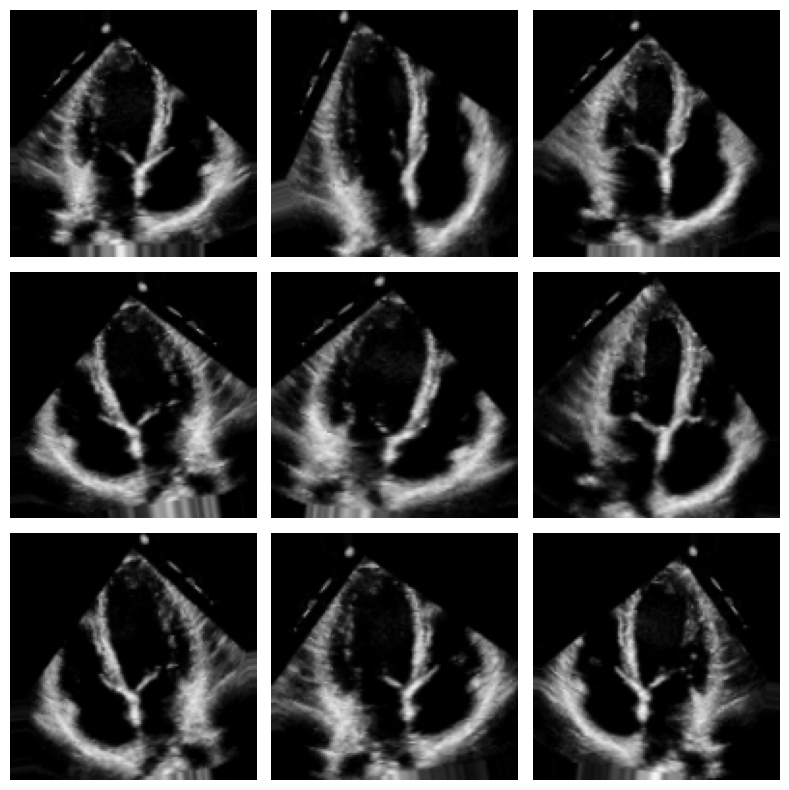

In [33]:
# Instantiate ImageDataGenerator to augment ultrasound images
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

# Get the first 9 images from the data
sample = X[:9]
augmented_iter = datagen.flow(sample, batch_size=9, shuffle=False)
augmented_imgs = next(augmented_iter)

# Visualize the first 9 augmented images
plt.figure(figsize=(8,8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # If pixels are normalized [0,1], convert back to [0,255]:
    img = (augmented_imgs[i] * 255).astype(np.uint8)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()

Keras' ImageDataGenerator is used to augment the ultrasound images by dynamically applying transformations, such as rotating the image, zooming in and flipping it horizontally to avoid over-augmentation and make the images too unrealistic 

In [34]:
# Follow a similar setup as in task 2 but using image augmentation and transfer learning

precision_scores, recall_scores, f1_scores, confusion_matrices = [], [], [], []
y_true_all = []
y_pred_proba_all = []

batch_size = 16
epochs = 30

# Create EarlyStopping callback used to prevent overfitting
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

start_time = time.perf_counter()

for train_idx, test_idx in cv.split(X, y):
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

    model = get_pretrained(IMG_HEIGHT, IMG_WIDTH)

    model.fit(
        datagen.flow(X_train, y_train, batch_size=batch_size),
        epochs=epochs,
        class_weight = class_weight,
        verbose=0,
        validation_data=(X_val, y_val),
        callbacks=callbacks
    )

    y_pred_proba = model.predict(X_test)
    y_true_all.extend(y_test)
    y_pred_proba_all.extend(y_pred_proba)

    y_pred = (y_pred_proba >= 0.5).astype(int)

    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    confusion_matrices.append(confusion_matrix(y_test, y_pred))

print(f'Elapsed time for 5-fold cross validation: {time.perf_counter() - start_time}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step   
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 959ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 959ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 936ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 963ms/step
Elapsed time for 5-fold cross validation: 610.0963379


Mean Cross-Val Precision: 0.9856960408684546
Mean Cross-Val Recall: 0.9706349206349205
Mean Cross-Val F1: 0.9777551493340967


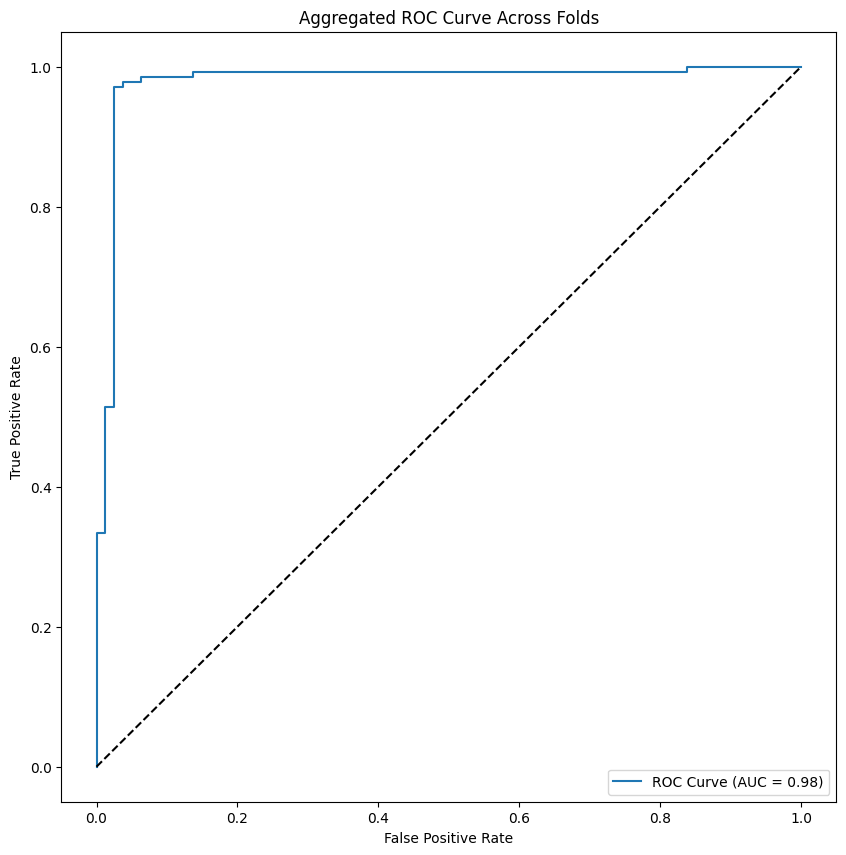

In [35]:
print(f'Mean Cross-Val Precision: {np.mean(precision_scores)}')
print(f'Mean Cross-Val Recall: {np.mean(recall_scores)}')
print(f'Mean Cross-Val F1: {np.mean(f1_scores)}')

plot_roc_curve(y_true_all, y_pred_proba_all)

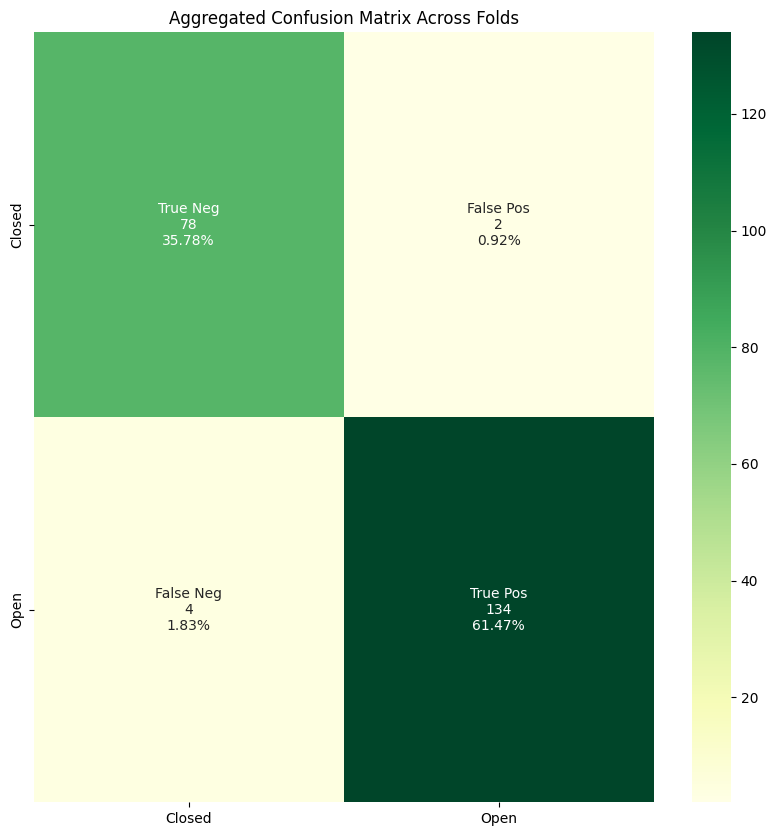

In [36]:
plot_confusion_matrix(confusion_matrices)

#### Evaluation

* The runtime has increased significantly when compared to SVC, which is expected due to a much larger model used
* Performance: all performance metrics have shown an improvement when compared to the result obtained in task 2 using SVC.
  - The confusion matrix shows, that both the number of False Positives (2) and False Negatives (4) have decreased - meaning that the new model has both, higher sensitivity to correctly identify ultrasound images where the Mitral valve is open and specificity to creectly classify images where the valve is closed 
 
At the cost of an increased runtime, using image augmentation with Transfer Learning, has resulted in an increased performance on all metrics when compared to the SVC used in task 2
 


References:

* Géron, A., 2022. Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: Concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html
* https://adriangb.com/scikeras/stable/
* https://medium.com/analytics-vidhya/generation-of-a-concatenated-confusion-matrix-in-cross-validation-912485c4a972
* https://towardsdatascience.com/understanding-the-roc-curve-and-auc-dd4f9a192ecb/
* https://keras.io/guides/transfer_learning/